In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.metrics import f1_score
%matplotlib inline
plt.style.use("seaborn-v0_8")

#### Загрузка данных

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')

In [3]:
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


#### Проверяем выборку на дисбаланс

Activity is 0: 45.77%
Activity is 1: 54.23%


C:\Users\ilyad\AppData\Local\Temp\ipykernel_7044\3357842927.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Activity', palette='CMRmap')


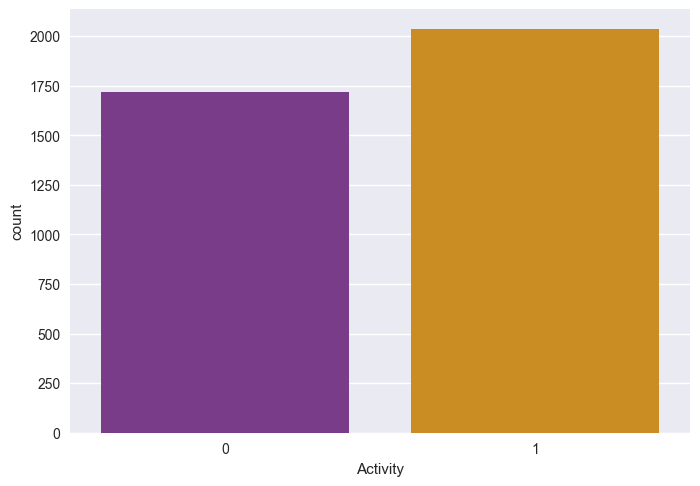

In [4]:
sns.countplot(data=data, x='Activity', palette='CMRmap')
activity_percent = data['Activity'].value_counts(normalize=True) * 100
print('Activity is 0: {:.2f}%'.format(activity_percent[0]))
print('Activity is 1: {:.2f}%'.format(activity_percent[1]))

>Выборку можно считать сбалансированной.

Разделим выборку на тренировочную и тестовую в соотношении 80/20.

In [5]:
X, y = data.drop('Activity', axis=1), data['Activity']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Оптимизация гиперпараметров модели

#### Логистическая регрессия

Зафиксируем метрику $F1$-score, полученную без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [6]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


c:\Users\ilyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### GridSearchCV

Пробуем подобрать оптимальные параметры с помощью поиска по сетке

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'penalty': ['l1', 'l2', 'none'] , # тип регуляризации
              'solver': ['saga'], # алгоритм оптимизации
               'C': [0.01, 0.35, 0.7, 1]}, # уровень силы регуляризации
                {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'], 
               'C': [0.01, 0.35, 0.7, 1]}, 
               {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear'], 
               'C': [0.01, 0.35, 0.7, 1]}
             ]

grid_search_1 = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid,
    scoring = 'f1', 
    cv=5, 
    n_jobs = -1
) 
%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [15]:
# Результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.674750,0.279115,0.021112,0.002404,0.01,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.774691,0.773885,0.756672,0.745710,0.737679,0.757727,0.014808,23
1,3.254085,0.104769,0.027908,0.010248,0.01,l2,saga,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.815362,0.791988,0.769006,0.791728,0.765766,0.786770,0.018034,5


In [16]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

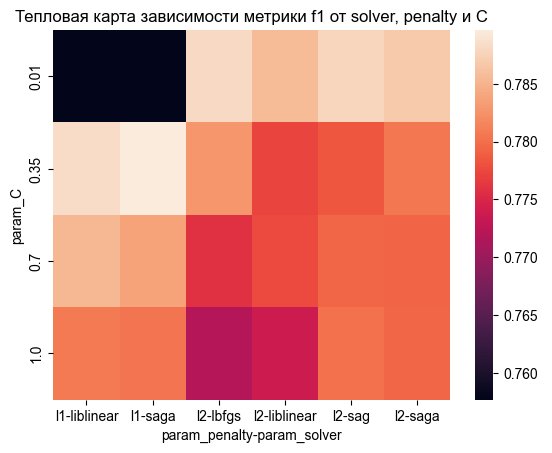

In [17]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики f1 от solver, penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Изучим область предполагаемого максимума метрики подробнее с помощью новой сетки.

In [18]:
param_grid = {'penalty': ['l1'] , # тип регуляризации
              'solver': ['saga', 'liblinear'], # алгоритм оптимизации
               'C': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}, # уровень силы регуляризации
grid_search_2 = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid,
    scoring = 'f1', 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 
y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))     

InvalidParameterError: The 'param_grid' parameter of GridSearchCV must be an instance of 'dict' or an instance of 'list'. Got ({'penalty': ['l1'], 'solver': ['saga', 'liblinear'], 'C': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]},) instead.

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.